### Test HuggingFace dataset usage

In [1]:
from datasets import load_dataset

# Will download and cache the dataset automatically
ds = load_dataset("amaai-lab/MidiCaps")

/home/yihsin/miniforge3/envs/mmpy11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 100%|██████████| 168385/168385 [00:01<00:00, 148497.76 examples/s]


In [2]:
print(ds)
print(ds['train'][0])  # Sample from training set

DatasetDict({
    train: Dataset({
        features: ['location', 'caption', 'genre', 'genre_prob', 'mood', 'mood_prob', 'key', 'time_signature', 'tempo', 'tempo_word', 'duration', 'duration_word', 'chord_summary', 'chord_summary_occurence', 'instrument_summary', 'instrument_numbers_sorted', 'all_chords', 'all_chords_timestamps', 'test_set'],
        num_rows: 168385
    })
})
{'location': 'lmd_full/1/1a0751ad20e2f82957410a7510a1b13e.mid', 'caption': 'A melodic electronic composition with classical influences, featuring a string ensemble, trumpet, brass section, synth strings, and drums. Set in F# minor with a 4/4 time signature, it moves at an Allegro tempo. The mood evokes a cinematic, spacious, and epic atmosphere while maintaining a sense of relaxation.', 'genre': ['electronic', 'classical'], 'genre_prob': [0.3596, 0.2367], 'mood': ['melodic', 'film', 'space', 'epic', 'relaxing'], 'mood_prob': [0.1228, 0.1114, 0.0917, 0.0828, 0.079], 'key': 'F# minor', 'time_signature': '4/4', 'tem

In [8]:
from torch.utils.data import Dataset

class MidiCapsDataset(Dataset):
    def __init__(self, hf_dataset):
        self.data = hf_dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        # Customize this based on dataset structure
        return {
            "input": item["location"],       # or load/process MIDI here
            "caption": item["caption"]        # example key
        }

In [9]:
from torch.utils.data import DataLoader

train_dataset = MidiCapsDataset(ds["train"])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [10]:
from torch.utils.data import DataLoader

# Assuming `train_loader` is already defined:
for batch in train_loader:
    print("Batch keys:", batch.keys())  # ['input', 'caption'] for example
    print("Input example:", batch['input'][0])  # Check first sample input
    print("Caption example:", batch['caption'][0])  # Check first sample caption
    break  # Remove this to loop over all batches

Batch keys: dict_keys(['input', 'caption'])
Input example: lmd_full/1/157e84c82fc923cb4e0ed7ada2fb4df6.mid
Caption example: A cheerful pop song with a touch of rock, featuring clean electric guitar, piano, flute, electric bass, and string ensemble, all coming together to create a melodic and motivational atmosphere. Set in the key of E minor with a moderate tempo of 92 beats per minute, this song maintains a 4/4 time signature throughout its duration, with the chords E and A/E providing the harmonic foundation.


### MMT preprocessing

#### Extraction Utils

In [26]:
"""Utility functions."""
import json
import pathlib
import warnings

import numpy as np


def save_args(filename, args):
    """Save the command-line arguments."""
    args_dict = {}
    for key, value in vars(args).items():
        if isinstance(value, pathlib.Path):
            args_dict[key] = str(value)
        else:
            args_dict[key] = value
    save_json(filename, args_dict)


def inverse_dict(d):
    """Return the inverse dictionary."""
    return {v: k for k, v in d.items()}


def save_txt(filename, data):
    """Save a list to a TXT file."""
    with open(filename, "w", encoding="utf8") as f:
        for item in data:
            f.write(f"{item}\n")


def load_txt(filename):
    """Load a TXT file as a list."""
    with open(filename, encoding="utf8") as f:
        return [line.strip() for line in f]


def save_json(filename, data):
    """Save data as a JSON file."""
    with open(filename, "w", encoding="utf8") as f:
        json.dump(data, f)


def load_json(filename):
    """Load data from a JSON file."""
    with open(filename, encoding="utf8") as f:
        return json.load(f)


def save_csv(filename, data, header=""):
    """Save data as a CSV file."""
    np.savetxt(
        filename, data, fmt="%d", delimiter=",", header=header, comments=""
    )


def load_csv(filename, skiprows=1):
    """Load data from a CSV file."""
    return np.loadtxt(filename, dtype=int, delimiter=",", skiprows=skiprows)


def ignore_exceptions(func):
    """Decorator that ignores all errors and warnings."""

    def inner(*args, **kwargs):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            try:
                return func(*args, **kwargs)
            except Exception:
                return None

    return inner


def resolve_paths(func):
    """Decorator that resolves all paths."""

    def inner(*args, **kwargs):
        parsed = func(*args, **kwargs)
        for key in vars(parsed).keys():
            if isinstance(getattr(parsed, key), pathlib.Path):
                setattr(
                    parsed, key, getattr(parsed, key).expanduser().resolve()
                )
        return parsed

    return inner


In [27]:
"""Representation utilities."""
import pathlib
import pprint

import muspy
import numpy as np
import pretty_midi

# Configuration
RESOLUTION = 12
MAX_BEAT = 1024
MAX_DURATION = 384  # Remember to modify known durations as well!

# Dimensions
# (NOTE: "type" must be the first dimension!)
# (NOTE: Remember to modify N_TOKENS as well!)
DIMENSIONS = ["type", "beat", "position", "pitch", "duration", "instrument"]
assert DIMENSIONS[0] == "type"

# Type
TYPE_CODE_MAP = {
    "start-of-song": 0,
    "instrument": 1,
    "start-of-notes": 2,
    "note": 3,
    "end-of-song": 4,
}
CODE_TYPE_MAP = inverse_dict(TYPE_CODE_MAP)

# Beat
BEAT_CODE_MAP = {i: i + 1 for i in range(MAX_BEAT + 1)}
BEAT_CODE_MAP[None] = 0
CODE_BEAT_MAP = inverse_dict(BEAT_CODE_MAP)

# Position
POSITION_CODE_MAP = {i: i + 1 for i in range(RESOLUTION)}
POSITION_CODE_MAP[None] = 0
CODE_POSITION_MAP = inverse_dict(POSITION_CODE_MAP)

# Pitch
PITCH_CODE_MAP = {i: i + 1 for i in range(128)}
PITCH_CODE_MAP[None] = 0
CODE_PITCH_MAP = inverse_dict(PITCH_CODE_MAP)

# Duration
KNOWN_DURATIONS = [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    15,
    16,
    18,
    20,
    21,
    24,
    30,
    36,
    40,
    42,
    48,
    60,
    72,
    84,
    96,
    120,
    144,
    168,
    192,
    384,
]
DURATION_CODE_MAP = {
    i: int(np.argmin(np.abs(np.array(KNOWN_DURATIONS) - i))) + 1
    for i in range(MAX_DURATION + 1)
}
DURATION_CODE_MAP[None] = 0
CODE_DURATION_MAP = {
    i + 1: duration for i, duration in enumerate(KNOWN_DURATIONS)
}

# Instrument
PROGRAM_INSTRUMENT_MAP = {
    # Pianos
    0: "piano",
    1: "piano",
    2: "piano",
    3: "piano",
    4: "electric-piano",
    5: "electric-piano",
    6: "harpsichord",
    7: "clavinet",
    # Chromatic Percussion
    8: "celesta",
    9: "glockenspiel",
    10: "music-box",
    11: "vibraphone",
    12: "marimba",
    13: "xylophone",
    14: "tubular-bells",
    15: "dulcimer",
    # Organs
    16: "organ",
    17: "organ",
    18: "organ",
    19: "church-organ",
    20: "organ",
    21: "accordion",
    22: "harmonica",
    23: "bandoneon",
    # Guitars
    24: "nylon-string-guitar",
    25: "steel-string-guitar",
    26: "electric-guitar",
    27: "electric-guitar",
    28: "electric-guitar",
    29: "electric-guitar",
    30: "electric-guitar",
    31: "electric-guitar",
    # Basses
    32: "bass",
    33: "electric-bass",
    34: "electric-bass",
    35: "electric-bass",
    36: "slap-bass",
    37: "slap-bass",
    38: "synth-bass",
    39: "synth-bass",
    # Strings
    40: "violin",
    41: "viola",
    42: "cello",
    43: "contrabass",
    44: "strings",
    45: "strings",
    46: "harp",
    47: "timpani",
    # Ensemble
    48: "strings",
    49: "strings",
    50: "synth-strings",
    51: "synth-strings",
    52: "voices",
    53: "voices",
    54: "voices",
    55: "orchestra-hit",
    # Brass
    56: "trumpet",
    57: "trombone",
    58: "tuba",
    59: "trumpet",
    60: "horn",
    61: "brasses",
    62: "synth-brasses",
    63: "synth-brasses",
    # Reed
    64: "soprano-saxophone",
    65: "alto-saxophone",
    66: "tenor-saxophone",
    67: "baritone-saxophone",
    68: "oboe",
    69: "english-horn",
    70: "bassoon",
    71: "clarinet",
    # Pipe
    72: "piccolo",
    73: "flute",
    74: "recorder",
    75: "pan-flute",
    76: None,
    77: None,
    78: None,
    79: "ocarina",
    # Synth Lead
    80: "lead",
    81: "lead",
    82: "lead",
    83: "lead",
    84: "lead",
    85: "lead",
    86: "lead",
    87: "lead",
    # Synth Pad
    88: "pad",
    89: "pad",
    90: "pad",
    91: "pad",
    92: "pad",
    93: "pad",
    94: "pad",
    95: "pad",
    # Synth Effects
    96: None,
    97: None,
    98: None,
    99: None,
    100: None,
    101: None,
    102: None,
    103: None,
    # Ethnic
    104: "sitar",
    105: "banjo",
    106: "shamisen",
    107: "koto",
    108: "kalimba",
    109: "bag-pipe",
    110: "violin",
    111: "shehnai",
    # Percussive
    112: None,
    113: None,
    114: None,
    115: None,
    116: None,
    117: "melodic-tom",
    118: "synth-drums",
    119: "synth-drums",
    # Sound effects
    120: None,
    121: None,
    122: None,
    123: None,
    124: None,
    125: None,
    126: None,
    127: None,
}
INSTRUMENT_PROGRAM_MAP = {
    # Pianos
    "piano": 0,
    "electric-piano": 4,
    "harpsichord": 6,
    "clavinet": 7,
    # Chromatic Percussion
    "celesta": 8,
    "glockenspiel": 9,
    "music-box": 10,
    "vibraphone": 11,
    "marimba": 12,
    "xylophone": 13,
    "tubular-bells": 14,
    "dulcimer": 15,
    # Organs
    "organ": 16,
    "church-organ": 19,
    "accordion": 21,
    "harmonica": 22,
    "bandoneon": 23,
    # Guitars
    "nylon-string-guitar": 24,
    "steel-string-guitar": 25,
    "electric-guitar": 26,
    # Basses
    "bass": 32,
    "electric-bass": 33,
    "slap-bass": 36,
    "synth-bass": 38,
    # Strings
    "violin": 40,
    "viola": 41,
    "cello": 42,
    "contrabass": 43,
    "harp": 46,
    "timpani": 47,
    # Ensemble
    "strings": 49,
    "synth-strings": 50,
    "voices": 52,
    "orchestra-hit": 55,
    # Brass
    "trumpet": 56,
    "trombone": 57,
    "tuba": 58,
    "horn": 60,
    "brasses": 61,
    "synth-brasses": 62,
    # Reed
    "soprano-saxophone": 64,
    "alto-saxophone": 65,
    "tenor-saxophone": 66,
    "baritone-saxophone": 67,
    "oboe": 68,
    "english-horn": 69,
    "bassoon": 70,
    "clarinet": 71,
    # Pipe
    "piccolo": 72,
    "flute": 73,
    "recorder": 74,
    "pan-flute": 75,
    "ocarina": 79,
    # Synth Lead
    "lead": 80,
    # Synth Pad
    "pad": 88,
    # Ethnic
    "sitar": 104,
    "banjo": 105,
    "shamisen": 106,
    "koto": 107,
    "kalimba": 108,
    "bag-pipe": 109,
    "shehnai": 111,
    # Percussive
    "melodic-tom": 117,
    "synth-drums": 118,
}
KNOWN_PROGRAMS = list(
    k for k, v in PROGRAM_INSTRUMENT_MAP.items() if v is not None
)
KNOWN_INSTRUMENTS = list(dict.fromkeys(INSTRUMENT_PROGRAM_MAP.keys()))
INSTRUMENT_CODE_MAP = {
    instrument: i + 1 for i, instrument in enumerate(KNOWN_INSTRUMENTS)
}
INSTRUMENT_CODE_MAP[None] = 0
CODE_INSTRUMENT_MAP = inverse_dict(INSTRUMENT_CODE_MAP)

N_TOKENS = [
    max(TYPE_CODE_MAP.values()) + 1,
    max(BEAT_CODE_MAP.values()) + 1,
    max(POSITION_CODE_MAP.values()) + 1,
    max(PITCH_CODE_MAP.values()) + 1,
    max(DURATION_CODE_MAP.values()) + 1,
    max(INSTRUMENT_CODE_MAP.values()) + 1,
]


def get_encoding():
    """Return the encoding configurations."""
    return {
        "resolution": RESOLUTION,
        "max_beat": MAX_BEAT,
        "max_duration": MAX_DURATION,
        "dimensions": DIMENSIONS,
        "n_tokens": N_TOKENS,
        "type_code_map": TYPE_CODE_MAP,
        "beat_code_map": BEAT_CODE_MAP,
        "position_code_map": POSITION_CODE_MAP,
        "pitch_code_map": PITCH_CODE_MAP,
        "duration_code_map": DURATION_CODE_MAP,
        "instrument_code_map": INSTRUMENT_CODE_MAP,
        "code_type_map": CODE_TYPE_MAP,
        "code_beat_map": CODE_BEAT_MAP,
        "code_position_map": CODE_POSITION_MAP,
        "code_pitch_map": CODE_PITCH_MAP,
        "code_duration_map": CODE_DURATION_MAP,
        "code_instrument_map": CODE_INSTRUMENT_MAP,
        "program_instrument_map": PROGRAM_INSTRUMENT_MAP,
        "instrument_program_map": INSTRUMENT_PROGRAM_MAP,
    }


def load_encoding(filename):
    """Load encoding configurations from a JSON file."""
    encoding = load_json(filename)
    for key in (
        "code_type_map",
        "code_beat_map",
        "code_position_map",
        "code_duration_map",
        "code_pitch_map",
        "code_instrument_map",
        "beat_code_map",
        "position_code_map",
        "duration_code_map",
        "pitch_code_map",
        "program_instrument_map",
    ):
        encoding[key] = {
            int(k) if k != "null" else None: v
            for k, v in encoding[key].items()
        }
    return encoding


def extract_notes(music, resolution):
    """Return a MusPy music object as a note sequence.

    Each row of the output is a note specified as follows.

        (beat, position, pitch, duration, program)

    """
    # Check resolution
    assert music.resolution == resolution

    # Extract notes
    notes = []
    for track in music:
        if track.is_drum or track.program not in KNOWN_PROGRAMS:
            continue
        for note in track:
            beat, position = divmod(note.time, resolution)
            if note.duration > 1026:
                print("[extract] note too long, truncate to 1025")
                notes.append(
                    (beat, position, note.pitch, 1026, track.program)
                )
            else:
                notes.append(
                    (beat, position, note.pitch, note.duration, track.program)
                )

    # Deduplicate and sort the notes
    notes = sorted(set(notes))

    return np.array(notes)


def encode_notes(notes, encoding):
    """Encode a note sequence into a sequence of codes.

    Each row of the input is a note specified as follows.

        (beat, position, pitch, duration, program)

    Each row of the output is encoded as follows.

        (event_type, beat, position, pitch, duration, instrument)

    """
    # Get variables
    max_beat = encoding["max_beat"]
    max_duration = encoding["max_duration"]

    # Get maps
    type_code_map = encoding["type_code_map"]
    beat_code_map = encoding["beat_code_map"]
    position_code_map = encoding["position_code_map"]
    pitch_code_map = encoding["pitch_code_map"]
    duration_code_map = encoding["duration_code_map"]
    instrument_code_map = encoding["instrument_code_map"]
    program_instrument_map = encoding["program_instrument_map"]

    # Get the dimension indices
    beat_dim = encoding["dimensions"].index("beat")
    position_dim = encoding["dimensions"].index("position")
    pitch_dim = encoding["dimensions"].index("pitch")
    duration_dim = encoding["dimensions"].index("duration")
    instrument_dim = encoding["dimensions"].index("instrument")

    # Start the codes with an SOS row
    codes = [(type_code_map["start-of-song"], 0, 0, 0, 0, 0)]

    # Extract instruments
    instruments = set(program_instrument_map[note[-1]] for note in notes)

    # Encode the instruments
    instrument_codes = []
    for instrument in instruments:
        # Skip unknown instruments
        if instrument is None:
            continue
        row = [type_code_map["instrument"], 0, 0, 0, 0, 0]
        row[instrument_dim] = instrument_code_map[instrument]
        instrument_codes.append(row)

    # Sort the instruments and append them to the code sequence
    instrument_codes.sort()
    codes.extend(instrument_codes)

    # Encode the notes
    codes.append((type_code_map["start-of-notes"], 0, 0, 0, 0, 0))
    for beat, position, pitch, duration, program in notes:
        # Skip if max_beat has reached
        if beat > max_beat:
            continue
        # Skip unknown instruments
        instrument = program_instrument_map[program]
        if instrument is None:
            continue
        # Encode the note
        row = [type_code_map["note"], 0, 0, 0, 0, 0]
        row[beat_dim] = beat_code_map[beat]
        row[position_dim] = position_code_map[position]
        row[pitch_dim] = pitch_code_map[pitch]
        row[duration_dim] = duration_code_map[min(duration, max_duration)]
        row[instrument_dim] = instrument_code_map[instrument]
        codes.append(row)

    # End the codes with an EOS row
    codes.append((type_code_map["end-of-song"], 0, 0, 0, 0, 0))

    return np.array(codes)


def encode(music, encoding):
    """Encode a MusPy music object into a sequence of codes.

    Each row of the input is encoded as follows.

        (event_type, beat, position, pitch, duration, instrument)

    Each row of the output is a note specified as follows.

        (beat, position, pitch, duration, program)

    """
    # Extract notes
    notes = extract_notes(music, encoding["resolution"])

    # Encode the notes
    codes = encode_notes(notes, encoding)

    return codes


def decode_notes(codes, encoding):
    """Decode codes into a note sequence.

    Each row of the input is encoded as follows.

        (event_type, beat, position, pitch, duration, instrument)

    """
    # Get variables and maps
    code_type_map = encoding["code_type_map"]
    code_beat_map = encoding["code_beat_map"]
    code_position_map = encoding["code_position_map"]
    code_pitch_map = encoding["code_pitch_map"]
    code_duration_map = encoding["code_duration_map"]
    code_instrument_map = encoding["code_instrument_map"]
    instrument_program_map = encoding["instrument_program_map"]

    # Get the dimension indices
    beat_dim = encoding["dimensions"].index("beat")
    position_dim = encoding["dimensions"].index("position")
    pitch_dim = encoding["dimensions"].index("pitch")
    duration_dim = encoding["dimensions"].index("duration")
    instrument_dim = encoding["dimensions"].index("instrument")

    # Decode the codes into a sequence of notes
    notes = []
    for row in codes:
        event_type = code_type_map[int(row[0])]
        if event_type in ("start-of-song", "instrument", "start-of-notes"):
            continue
        elif event_type == "end-of-song":
            break
        elif event_type == "note":
            beat = code_beat_map[int(row[beat_dim])]
            position = code_position_map[int(row[position_dim])]
            pitch = code_pitch_map[int(row[pitch_dim])]
            duration = code_duration_map[int(row[duration_dim])]
            instrument = code_instrument_map[int(row[instrument_dim])]
            program = instrument_program_map[instrument]
            notes.append((beat, position, pitch, duration, program))
        else:
            raise ValueError("Unknown event type.")

    return notes


def reconstruct(notes, resolution):
    """Reconstruct a note sequence to a MusPy Music object."""
    # Construct the MusPy Music object
    music = muspy.Music(resolution=resolution, tempos=[muspy.Tempo(0, 100)])

    # Append the tracks
    programs = sorted(set(note[-1] for note in notes))
    for program in programs:
        music.tracks.append(muspy.Track(program))

    # Append the notes
    for beat, position, pitch, duration, program in notes:
        time = beat * resolution + position
        track_idx = programs.index(program)
        music[track_idx].notes.append(muspy.Note(time, pitch, duration))

    return music


def decode(codes, encoding):
    """Decode codes into a MusPy Music object.

    Each row of the input is encoded as follows.

        (event_type, beat, position, pitch, duration, instrument)

    """
    # Get resolution
    resolution = encoding["resolution"]

    # Decode codes into a note sequence
    notes = decode_notes(codes, encoding)

    # Reconstruct the music object
    music = reconstruct(notes, resolution)

    return music


def dump(data, encoding):
    """Decode the codes and dump as a string."""
    # Get maps
    code_type_map = encoding["code_type_map"]
    code_beat_map = encoding["code_beat_map"]
    code_position_map = encoding["code_position_map"]
    code_pitch_map = encoding["code_pitch_map"]
    code_duration_map = encoding["code_duration_map"]
    code_instrument_map = encoding["code_instrument_map"]

    # Get the dimension indices
    beat_dim = encoding["dimensions"].index("beat")
    position_dim = encoding["dimensions"].index("position")
    pitch_dim = encoding["dimensions"].index("pitch")
    duration_dim = encoding["dimensions"].index("duration")
    instrument_dim = encoding["dimensions"].index("instrument")

    # Iterate over the rows
    lines = []
    for row in data:
        event_type = code_type_map[int(row[0])]
        if event_type == "start-of-song":
            lines.append("Start of song")
        elif event_type == "end-of-song":
            lines.append("End of song")
        elif event_type == "instrument":
            instrument = code_instrument_map[int(row[instrument_dim])]
            lines.append(f"Instrument: {instrument}")
        elif event_type == "start-of-notes":
            lines.append("Start of notes")
        elif event_type == "note":
            beat = code_beat_map[int(row[beat_dim])]
            position = code_position_map[int(row[position_dim])]
            pitch = pretty_midi.note_number_to_name(
                code_pitch_map[int(row[pitch_dim])]
            )
            duration = code_duration_map[int(row[duration_dim])]
            instrument = code_instrument_map[int(row[instrument_dim])]
            lines.append(
                f"Note: beat={beat}, position={position}, pitch={pitch}, "
                f"duration={duration}, instrument={instrument}"
            )
        else:
            raise ValueError(f"Unknown event type: {event_type}")

    return "\n".join(lines)


def save_txt(filename, data, encoding):
    """Dump the codes into a TXT file."""
    with open(filename, "w") as f:
        f.write(dump(data, encoding))


def save_csv_notes(filename, data):
    """Save the representation as a CSV file."""
    assert data.shape[1] == 5
    np.savetxt(
        filename,
        data,
        fmt="%d",
        delimiter=",",
        header="beat,position,pitch,duration,program",
        comments="",
    )


def save_csv_codes(filename, data):
    """Save the representation as a CSV file."""
    assert data.shape[1] == 6
    np.savetxt(
        filename,
        data,
        fmt="%d",
        delimiter=",",
        header="type,beat,position,pitch,duration,instrument",
        comments="",
    )

#### Preprocessing

In [28]:
from pathlib import Path
# dim 1->6, train.
base_dir = Path("/home/yihsin/dataset/midicaps")
output_train = Path("/home/yihsin/dataset/midicaps-mini-parsed-mmt/train")
output_valid = Path("/home/yihsin/dataset/midicaps-mini-parsed-mmt/valid")
output_train.mkdir(parents=True, exist_ok=True)
output_valid.mkdir(parents=True, exist_ok=True)

In [29]:
# get 1/10 of the dataset
import random
import numpy as np
from pathlib import Path

# Base directory containing subfolders
base_dir = Path(base_dir)

# Recursively find all .mid files
all_mid_files = list(base_dir.rglob("*.mid"))
print(f"Found {len(all_mid_files)} MIDI files.")

# Randomly pick 1/10 of them
sample_size = max(1, len(all_mid_files) // 10)
sampled_files = random.sample(all_mid_files, sample_size)

# Convert to list of strings (paths)
sampled_file_paths = [str(p) for p in sampled_files]

Found 168385 MIDI files.


In [30]:
# Find all MIDI files, split train and valid set
all_mid_files = sampled_file_paths
print(f"Found {len(all_mid_files)} MIDI files.")

num_valid = max(1, len(all_mid_files) // 500)
valid_set = set(all_mid_files[:num_valid])

Found 16838 MIDI files.


In [31]:
from pathlib import Path
import numpy as np
import muspy

def process_file(mid_path):
    try:
        pth_obj = Path(mid_path)
        relative = pth_obj.relative_to(base_dir)
        subfolder = relative.parts[-2]
        stem = pth_obj.stem
        filename = f"{subfolder}_{stem}.npy"

        music = muspy.read(mid_path)
        resolution = 12
        music.adjust_resolution(resolution)

        for track in music:
            for note in track:
                if note.duration == 0:
                    note.duration = 1
        music.remove_duplicate()

        end_time = music.get_end_time()
        if end_time > resolution * 4 * 2000 or end_time < resolution * 4 * 10:
            return f"[!] Invalid end time {mid_path}: {end_time}"

        notes = extract_notes(music, resolution)
        if len(notes) < 50:
            return f"[!] Not enough notes {mid_path}: {len(notes)}"

        notes[:, 0] = notes[:, 0] - notes[0, 0]

        if mid_path in valid_set:
            out_path = output_valid / filename
        else:
            out_path = output_train / filename

        np.save(out_path, notes)
        return None  # No error
    except Exception as e:
        return f"[!] Failed to process {mid_path}: {e}"

In [32]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

errors = []
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(process_file, mid_path) for mid_path in all_mid_files]
    for f in tqdm(as_completed(futures), total=len(futures), desc="Processing MIDI files"):
        result = f.result()
        if result is not None:
            errors.append(result)

for err in errors:
    print(err)

Processing MIDI files:   1%|          | 152/16838 [00:12<14:04, 19.76it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   1%|          | 155/16838 [00:13<29:45,  9.34it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   1%|          | 158/16838 [00:13<24:54, 11.16it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:   1%|          | 160/16838 [00:13<23:13, 11.97it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   1%|          | 173/16838 [00:14<31:07,  8.93it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   1%|          | 183/16838 [00:15<39:42,  6.99it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   1%|          | 185/16838 [00:16<41:31,  6.68it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   1%|          | 203/16838 [00:17<20:38, 13.43it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   2%|▏         | 306/16838 [00:27<13:19, 20.69it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:   2%|▏         | 309/16838 [00:27<13:33, 20.32it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   2%|▏         | 312/16838 [00:27<13:51, 19.86it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:   2%|▏         | 336/16838 [00:30<29:20,  9.37it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:   2%|▏         | 339/16838 [00:30<23:22, 11.76it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   2%|▏         | 341/16838 [00:30<22:05, 12.45it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate 

Processing MIDI files:   2%|▏         | 343/16838 [00:30<24:27, 11.24it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   2%|▏         | 347/16838 [00:30<17:52, 15.38it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   2%|▏         | 349/16838 [00:30<21:23, 12.85it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:   2%|▏         | 351/16838 [00:31<19:48, 13.87it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate

Processing MIDI files:   2%|▏         | 354/16838 [00:31<21:20, 12.87it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate 

Processing MIDI files:   2%|▏         | 356/16838 [00:31<26:51, 10.23it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate 

Processing MIDI files:   2%|▏         | 358/16838 [00:31<28:38,  9.59it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate 

Processing MIDI files:   2%|▏         | 360/16838 [00:32<28:09,  9.76it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   2%|▏         | 363/16838 [00:32<21:58, 12.49it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   2%|▏         | 391/16838 [00:34<25:14, 10.86it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:   2%|▏         | 394/16838 [00:34<20:42, 13.23it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   3%|▎         | 421/16838 [00:36<11:46, 23.24it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   3%|▎         | 424/16838 [00:36<15:33, 17.58it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:   3%|▎         | 426/16838 [00:36<16:11, 16.89it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate

Processing MIDI files:   3%|▎         | 429/16838 [00:36<21:45, 12.57it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:   3%|▎         | 431/16838 [00:36<20:14, 13.51it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   3%|▎         | 434/16838 [00:37<19:23, 14.10it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:   3%|▎         | 440/16838 [00:37<12:43, 21.48it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   3%|▎         | 485/16838 [00:40<17:39, 15.43it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   3%|▎         | 537/16838 [00:44<24:38, 11.03it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:   3%|▎         | 575/16838 [00:48<24:59, 10.84it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:   3%|▎         | 587/16838 [00:48<16:52, 16.05it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate 

Processing MIDI files:   4%|▎         | 590/16838 [00:49<23:36, 11.47it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate 

Processing MIDI files:   4%|▎         | 592/16838 [00:49<30:29,  8.88it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:   4%|▎         | 595/16838 [00:49<25:04, 10.79it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:   4%|▎         | 601/16838 [00:49<15:36, 17.34it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025[extract] note too long, truncate 

Processing MIDI files:   4%|▎         | 604/16838 [00:50<21:13, 12.75it/s]

[extract] note too long, truncate to 1025

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:   4%|▎         | 607/16838 [00:50<19:04, 14.18it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:   4%|▎         | 610/16838 [00:50<16:56, 15.97it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025[extract] note too long, truncate to 1025

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:   4%|▎         | 613/16838 [00:50<17:57, 15.06it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate

Processing MIDI files:   4%|▎         | 615/16838 [00:51<21:57, 12.31it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   4%|▎         | 618/16838 [00:51<18:07, 14.92it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:   4%|▎         | 620/16838 [00:51<18:57, 14.26it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate

Processing MIDI files:   4%|▎         | 622/16838 [00:51<25:02, 10.79it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate 

Processing MIDI files:   4%|▎         | 624/16838 [00:51<25:31, 10.58it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   4%|▎         | 626/16838 [00:52<25:42, 10.51it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   4%|▎         | 628/16838 [00:52<26:16, 10.28it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   4%|▎         | 630/16838 [00:52<23:22, 11.56it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate 

Processing MIDI files:   4%|▍         | 634/16838 [00:52<19:47, 13.64it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:   4%|▍         | 636/16838 [00:52<20:10, 13.38it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate

Processing MIDI files:   4%|▍         | 638/16838 [00:53<40:17,  6.70it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   4%|▍         | 641/16838 [00:53<30:21,  8.89it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

[extract] note too long, truncate to 1025

Processing MIDI files:   4%|▍         | 643/16838 [00:53<27:06,  9.96it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate 

Processing MIDI files:   4%|▍         | 685/16838 [00:57<20:55, 12.86it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:   4%|▍         | 687/16838 [00:57<21:59, 12.24it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:   5%|▌         | 889/16838 [01:13<26:00, 10.22it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   5%|▌         | 925/16838 [01:16<22:47, 11.63it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   6%|▌         | 1005/16838 [01:25<33:36,  7.85it/s] 

[extract] note too long, truncate to 1025


Processing MIDI files:   6%|▌         | 1030/16838 [01:27<22:00, 11.97it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:   6%|▋         | 1093/16838 [01:32<21:07, 12.43it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:   7%|▋         | 1142/16838 [01:37<29:53,  8.75it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   7%|▋         | 1224/16838 [01:44<17:43, 14.68it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   8%|▊         | 1266/16838 [01:48<15:42, 16.53it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   8%|▊         | 1288/16838 [01:49<24:41, 10.49it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:   8%|▊         | 1352/16838 [01:56<25:57,  9.94it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:   9%|▉         | 1565/16838 [02:15<26:22,  9.65it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  10%|▉         | 1639/16838 [02:24<26:58,  9.39it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  10%|█         | 1739/16838 [02:33<28:14,  8.91it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  11%|█         | 1789/16838 [02:38<17:12, 14.57it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  11%|█         | 1856/16838 [02:43<13:20, 18.71it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  11%|█         | 1882/16838 [02:45<20:00, 12.46it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  12%|█▏        | 1948/16838 [02:50<19:58, 12.42it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  12%|█▏        | 1954/16838 [02:50<21:21, 11.62it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  12%|█▏        | 1999/16838 [02:54<28:21,  8.72it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  12%|█▏        | 2005/16838 [02:54<24:13, 10.21it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  12%|█▏        | 2010/16838 [02:55<29:04,  8.50it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  13%|█▎        | 2140/16838 [03:08<24:33,  9.97it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  13%|█▎        | 2152/16838 [03:10<28:05,  8.71it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  13%|█▎        | 2154/16838 [03:10<25:01,  9.78it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  13%|█▎        | 2177/16838 [03:11<14:34, 16.77it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  13%|█▎        | 2188/16838 [03:12<14:50, 16.45it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  13%|█▎        | 2192/16838 [03:12<15:27, 15.80it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  13%|█▎        | 2198/16838 [03:12<10:52, 22.45it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  14%|█▎        | 2288/16838 [03:20<20:55, 11.59it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  14%|█▍        | 2317/16838 [03:23<31:08,  7.77it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  15%|█▌        | 2608/16838 [03:54<22:49, 10.39it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  16%|█▋        | 2739/16838 [04:05<14:26, 16.27it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  16%|█▋        | 2778/16838 [04:09<27:58,  8.37it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  17%|█▋        | 2782/16838 [04:09<20:09, 11.63it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  17%|█▋        | 2792/16838 [04:10<27:54,  8.39it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  17%|█▋        | 2793/16838 [04:11<29:37,  7.90it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  17%|█▋        | 2826/16838 [04:14<24:58,  9.35it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  17%|█▋        | 2848/16838 [04:17<41:08,  5.67it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  17%|█▋        | 2859/16838 [04:19<29:37,  7.86it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  17%|█▋        | 2909/16838 [04:24<12:25, 18.68it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  18%|█▊        | 2976/16838 [04:29<13:50, 16.69it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  18%|█▊        | 2980/16838 [04:30<22:32, 10.25it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  19%|█▊        | 3118/16838 [04:42<20:59, 10.89it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  19%|█▉        | 3186/16838 [04:49<16:51, 13.50it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  19%|█▉        | 3199/16838 [04:49<12:04, 18.84it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  19%|█▉        | 3245/16838 [04:54<21:43, 10.42it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  19%|█▉        | 3247/16838 [04:54<20:25, 11.09it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  20%|██        | 3407/16838 [05:08<26:10,  8.55it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  20%|██        | 3411/16838 [05:08<29:42,  7.53it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  20%|██        | 3432/16838 [05:10<21:36, 10.34it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  20%|██        | 3434/16838 [05:10<19:09, 11.66it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate 

Processing MIDI files:  21%|██        | 3575/16838 [05:27<27:35,  8.01it/s]  

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  21%|██▏       | 3582/16838 [05:28<26:23,  8.37it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  22%|██▏       | 3633/16838 [05:33<14:46, 14.90it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  22%|██▏       | 3639/16838 [05:33<17:40, 12.44it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  22%|██▏       | 3714/16838 [05:39<13:50, 15.81it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  22%|██▏       | 3721/16838 [05:39<13:15, 16.49it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  22%|██▏       | 3731/16838 [05:40<15:13, 14.35it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  22%|██▏       | 3759/16838 [05:43<17:57, 12.13it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  22%|██▏       | 3771/16838 [05:44<22:09,  9.83it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  22%|██▏       | 3784/16838 [05:46<18:37, 11.68it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  23%|██▎       | 3900/16838 [06:01<28:36,  7.54it/s]  

[extract] note too long, truncate to 1025


Processing MIDI files:  23%|██▎       | 3934/16838 [06:04<16:08, 13.33it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  24%|██▎       | 3974/16838 [06:08<30:00,  7.15it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  24%|██▎       | 3978/16838 [06:08<27:22,  7.83it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  24%|██▍       | 4005/16838 [06:10<12:35, 16.99it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  24%|██▍       | 4015/16838 [06:11<24:02,  8.89it/s]

[extract] note too long, truncate to 1025

Processing MIDI files:  24%|██▍       | 4017/16838 [06:11<21:37,  9.88it/s]


[extract] note too long, truncate to 1025


Processing MIDI files:  25%|██▍       | 4178/16838 [06:25<40:10,  5.25it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:  25%|██▍       | 4180/16838 [06:25<41:44,  5.05it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  25%|██▍       | 4195/16838 [06:27<22:43,  9.27it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  25%|██▌       | 4272/16838 [06:34<13:21, 15.68it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  26%|██▌       | 4363/16838 [06:42<30:04,  6.91it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  26%|██▌       | 4386/16838 [06:45<34:49,  5.96it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  26%|██▌       | 4403/16838 [06:47<20:17, 10.22it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  26%|██▋       | 4459/16838 [06:55<30:58,  6.66it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  27%|██▋       | 4479/16838 [06:57<11:00, 18.70it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  27%|██▋       | 4490/16838 [06:58<28:25,  7.24it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  27%|██▋       | 4621/16838 [07:16<21:25,  9.50it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  27%|██▋       | 4623/16838 [07:16<25:40,  7.93it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  28%|██▊       | 4712/16838 [07:26<28:01,  7.21it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  28%|██▊       | 4761/16838 [07:31<15:31, 12.96it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  29%|██▊       | 4809/16838 [07:36<17:32, 11.43it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  29%|██▊       | 4811/16838 [07:37<26:50,  7.47it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:  29%|██▊       | 4814/16838 [07:37<20:00, 10.02it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  30%|██▉       | 4986/16838 [07:52<16:08, 12.24it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  30%|██▉       | 5007/16838 [07:55<18:28, 10.67it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  30%|██▉       | 5021/16838 [07:57<20:11,  9.75it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  30%|███       | 5098/16838 [08:03<22:18,  8.77it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  30%|███       | 5117/16838 [08:05<11:10, 17.49it/s]

[extract] note too long, truncate to 1025

Processing MIDI files:  30%|███       | 5125/16838 [08:05<06:46, 28.83it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:  30%|███       | 5129/16838 [08:05<08:29, 22.96it/s]

Processing MIDI files:  31%|███       | 5178/16838 [08:09<16:20, 11.89it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  31%|███       | 5205/16838 [08:13<26:17,  7.37it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  31%|███       | 5213/16838 [08:13<18:15, 10.61it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  31%|███       | 5230/16838 [08:15<21:10,  9.13it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  31%|███▏      | 5262/16838 [08:17<15:34, 12.39it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  31%|███▏      | 5280/16838 [08:19<19:03, 10.10it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  32%|███▏      | 5319/16838 [08:23<20:23,  9.41it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  32%|███▏      | 5329/16838 [08:24<16:35, 11.56it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  32%|███▏      | 5382/16838 [08:29<21:43,  8.79it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  32%|███▏      | 5453/16838 [08:34<14:39, 12.94it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  32%|███▏      | 5455/16838 [08:34<15:04, 12.59it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  33%|███▎      | 5538/16838 [08:41<24:19,  7.74it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  33%|███▎      | 5545/16838 [08:42<27:13,  6.91it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:  33%|███▎      | 5547/16838 [08:43<22:00,  8.55it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  33%|███▎      | 5557/16838 [08:44<32:49,  5.73it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  33%|███▎      | 5580/16838 [08:46<11:31, 16.27it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  33%|███▎      | 5621/16838 [08:50<20:11,  9.26it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  34%|███▎      | 5643/16838 [08:53<26:44,  6.98it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  34%|███▍      | 5692/16838 [08:58<17:04, 10.88it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  34%|███▍      | 5700/16838 [08:58<16:53, 10.99it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  34%|███▍      | 5774/16838 [09:05<20:13,  9.11it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  34%|███▍      | 5778/16838 [09:06<19:22,  9.51it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  34%|███▍      | 5784/16838 [09:07<21:55,  8.40it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:  34%|███▍      | 5786/16838 [09:07<20:28,  8.99it/s]


[extract] note too long, truncate to 1025


Processing MIDI files:  35%|███▍      | 5814/16838 [09:09<11:55, 15.40it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  35%|███▍      | 5816/16838 [09:09<13:29, 13.62it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  35%|███▌      | 5902/16838 [09:15<14:27, 12.60it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  36%|███▌      | 6032/16838 [09:30<15:52, 11.34it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  36%|███▌      | 6054/16838 [09:32<20:40,  8.69it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  37%|███▋      | 6159/16838 [09:42<17:14, 10.32it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  37%|███▋      | 6167/16838 [09:42<09:23, 18.94it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  37%|███▋      | 6209/16838 [09:46<18:20,  9.66it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  37%|███▋      | 6236/16838 [09:48<16:38, 10.61it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  38%|███▊      | 6393/16838 [10:01<11:07, 15.66it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  38%|███▊      | 6404/16838 [10:02<16:40, 10.43it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  38%|███▊      | 6448/16838 [10:07<20:51,  8.30it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  38%|███▊      | 6458/16838 [10:07<11:54, 14.54it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  39%|███▉      | 6573/16838 [10:19<17:34,  9.73it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  39%|███▉      | 6577/16838 [10:19<15:26, 11.07it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  40%|███▉      | 6652/16838 [10:25<08:46, 19.36it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:  40%|███▉      | 6655/16838 [10:25<08:57, 18.95it/s]

Processing MIDI files:  40%|███▉      | 6709/16838 [10:31<15:00, 11.24it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  40%|███▉      | 6720/16838 [10:32<11:44, 14.35it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  40%|████      | 6804/16838 [10:39<12:14, 13.66it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  41%|████      | 6871/16838 [10:46<36:24,  4.56it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  41%|████▏     | 6969/16838 [10:57<20:48,  7.90it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  41%|████▏     | 6976/16838 [10:57<11:54, 13.80it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  42%|████▏     | 6993/16838 [10:58<13:34, 12.08it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  42%|████▏     | 7018/16838 [11:00<17:20,  9.44it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  42%|████▏     | 7072/16838 [11:05<11:31, 14.12it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  42%|████▏     | 7121/16838 [11:09<12:39, 12.79it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  42%|████▏     | 7134/16838 [11:11<25:27,  6.35it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  43%|████▎     | 7231/16838 [11:22<15:13, 10.52it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  43%|████▎     | 7239/16838 [11:22<13:58, 11.44it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  43%|████▎     | 7241/16838 [11:23<20:22,  7.85it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  43%|████▎     | 7250/16838 [11:23<14:06, 11.32it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  44%|████▎     | 7362/16838 [11:33<15:24, 10.25it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  44%|████▍     | 7433/16838 [11:38<11:46, 13.31it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  44%|████▍     | 7460/16838 [11:41<13:01, 12.00it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  44%|████▍     | 7471/16838 [11:43<28:45,  5.43it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  44%|████▍     | 7489/16838 [11:45<13:12, 11.80it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  45%|████▍     | 7506/16838 [11:47<30:30,  5.10it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  45%|████▌     | 7590/16838 [11:54<10:40, 14.43it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  45%|████▌     | 7594/16838 [11:54<10:54, 14.13it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  45%|████▌     | 7597/16838 [11:54<09:58, 15.45it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  46%|████▌     | 7672/16838 [12:01<10:05, 15.15it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  46%|████▌     | 7719/16838 [12:03<09:14, 16.44it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  46%|████▌     | 7721/16838 [12:03<09:03, 16.79it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  47%|████▋     | 7886/16838 [12:16<11:17, 13.22it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  47%|████▋     | 7971/16838 [12:23<13:00, 11.35it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  48%|████▊     | 8004/16838 [12:26<12:12, 12.06it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  48%|████▊     | 8006/16838 [12:27<21:18,  6.91it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  48%|████▊     | 8036/16838 [12:30<09:43, 15.08it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  49%|████▉     | 8224/16838 [12:45<08:31, 16.84it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  49%|████▉     | 8270/16838 [12:50<12:36, 11.32it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  49%|████▉     | 8303/16838 [12:52<09:22, 15.17it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  50%|████▉     | 8347/16838 [12:57<13:40, 10.35it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:  50%|████▉     | 8349/16838 [12:58<16:01,  8.83it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  50%|████▉     | 8400/16838 [13:02<14:15,  9.87it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  50%|█████     | 8437/16838 [13:05<12:47, 10.95it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  50%|█████     | 8439/16838 [13:06<15:24,  9.09it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  50%|█████     | 8448/16838 [13:06<09:21, 14.94it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  50%|█████     | 8474/16838 [13:09<10:15, 13.58it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  50%|█████     | 8476/16838 [13:10<23:34,  5.91it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  50%|█████     | 8489/16838 [13:11<14:23,  9.67it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  50%|█████     | 8499/16838 [13:11<07:10, 19.39it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  50%|█████     | 8502/16838 [13:11<06:37, 20.96it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  51%|█████     | 8512/16838 [13:12<11:56, 11.63it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:  51%|█████     | 8514/16838 [13:13<18:16,  7.59it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  51%|█████     | 8533/16838 [13:15<15:15,  9.07it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:  51%|█████     | 8535/16838 [13:16<16:05,  8.60it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate

Processing MIDI files:  51%|█████     | 8537/16838 [13:16<17:27,  7.92it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  51%|█████     | 8543/16838 [13:17<14:50,  9.32it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  51%|█████     | 8625/16838 [13:23<11:14, 12.18it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  51%|█████▏    | 8637/16838 [13:23<07:46, 17.57it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:  51%|█████▏    | 8639/16838 [13:24<09:39, 14.16it/s]

Processing MIDI files:  52%|█████▏    | 8678/16838 [13:27<11:25, 11.91it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  52%|█████▏    | 8743/16838 [13:34<10:30, 12.85it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  52%|█████▏    | 8772/16838 [13:36<09:29, 14.16it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  53%|█████▎    | 8918/16838 [13:47<13:49,  9.54it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  53%|█████▎    | 8964/16838 [13:51<11:19, 11.60it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  53%|█████▎    | 8970/16838 [13:52<14:50,  8.83it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  54%|█████▍    | 9087/16838 [14:01<11:41, 11.05it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  55%|█████▍    | 9197/16838 [14:12<11:47, 10.80it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  55%|█████▌    | 9278/16838 [14:21<12:25, 10.14it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025[extract] note too long, truncate to 1025



Processing MIDI files:  56%|█████▌    | 9357/16838 [14:29<10:29, 11.88it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  56%|█████▌    | 9387/16838 [14:32<14:15,  8.71it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  56%|█████▌    | 9389/16838 [14:33<16:11,  7.67it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  56%|█████▋    | 9494/16838 [14:41<08:54, 13.73it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  57%|█████▋    | 9545/16838 [14:46<13:18,  9.14it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  57%|█████▋    | 9589/16838 [14:50<17:30,  6.90it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  57%|█████▋    | 9613/16838 [14:53<18:00,  6.69it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  57%|█████▋    | 9666/16838 [14:58<06:11, 19.33it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  58%|█████▊    | 9738/16838 [15:04<11:24, 10.38it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  58%|█████▊    | 9841/16838 [15:12<09:47, 11.91it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  58%|█████▊    | 9846/16838 [15:13<07:56, 14.67it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  58%|█████▊    | 9848/16838 [15:13<09:25, 12.36it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  59%|█████▊    | 9873/16838 [15:15<10:49, 10.72it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  59%|█████▉    | 9908/16838 [15:18<05:54, 19.53it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  59%|█████▉    | 9914/16838 [15:18<07:21, 15.69it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  59%|█████▉    | 9997/16838 [15:24<04:40, 24.38it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  60%|█████▉    | 10065/16838 [15:28<07:25, 15.21it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  60%|██████    | 10148/16838 [15:38<16:05,  6.93it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  60%|██████    | 10160/16838 [15:39<11:42,  9.50it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  61%|██████    | 10206/16838 [15:43<07:49, 14.12it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  61%|██████    | 10227/16838 [15:45<10:01, 10.99it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:  61%|██████    | 10231/16838 [15:45<07:51, 14.02it/s]


[extract] note too long, truncate to 1025


Processing MIDI files:  61%|██████    | 10260/16838 [15:47<07:24, 14.80it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  61%|██████▏   | 10322/16838 [15:53<12:18,  8.82it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate 

Processing MIDI files:  61%|██████▏   | 10324/16838 [15:54<15:28,  7.02it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  62%|██████▏   | 10378/16838 [15:57<16:36,  6.48it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  62%|██████▏   | 10417/16838 [16:02<22:56,  4.67it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  62%|██████▏   | 10419/16838 [16:02<16:35,  6.44it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  62%|██████▏   | 10425/16838 [16:03<17:09,  6.23it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  62%|██████▏   | 10455/16838 [16:05<07:37, 13.95it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  62%|██████▏   | 10505/16838 [16:09<05:14, 20.15it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  62%|██████▏   | 10508/16838 [16:09<07:21, 14.33it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate 

Processing MIDI files:  62%|██████▏   | 10511/16838 [16:10<08:32, 12.36it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  63%|██████▎   | 10549/16838 [16:12<08:45, 11.96it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:  63%|██████▎   | 10551/16838 [16:12<08:17, 12.64it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025[extract] note too long, truncate to 1025

[extract] note too long, truncate to 1025


Processing MIDI files:  63%|██████▎   | 10591/16838 [16:18<11:34,  8.99it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  63%|██████▎   | 10601/16838 [16:19<11:30,  9.03it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  63%|██████▎   | 10669/16838 [16:24<08:11, 12.55it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  64%|██████▍   | 10736/16838 [16:31<10:55,  9.30it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  64%|██████▍   | 10768/16838 [16:33<05:47, 17.45it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

[extract] note too long, truncate to 1025[extract] note too long, truncate to 1025

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  64%|██████▍   | 10773/16838 [16:33<04:23, 22.97it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate 

Processing MIDI files:  64%|██████▍   | 10776/16838 [16:33<06:09, 16.40it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate 

Processing MIDI files:  64%|██████▍   | 10779/16838 [16:33<06:19, 15.98it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  64%|██████▍   | 10856/16838 [16:39<07:47, 12.81it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  65%|██████▍   | 10933/16838 [16:46<10:58,  8.97it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  66%|██████▌   | 11101/16838 [17:02<06:53, 13.87it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  66%|██████▋   | 11162/16838 [17:07<11:11,  8.45it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  67%|██████▋   | 11216/16838 [17:11<05:39, 16.57it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  67%|██████▋   | 11271/16838 [17:16<07:54, 11.73it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  67%|██████▋   | 11295/16838 [17:18<07:11, 12.85it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  67%|██████▋   | 11310/16838 [17:19<04:31, 20.37it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  67%|██████▋   | 11313/16838 [17:19<05:45, 15.99it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  67%|██████▋   | 11361/16838 [17:24<10:12,  8.94it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  68%|██████▊   | 11411/16838 [17:28<09:10,  9.85it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  69%|██████▉   | 11601/16838 [17:43<06:04, 14.36it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  69%|██████▉   | 11625/16838 [17:45<06:42, 12.96it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  69%|██████▉   | 11631/16838 [17:45<06:43, 12.90it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  69%|██████▉   | 11639/16838 [17:46<07:10, 12.07it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  69%|██████▉   | 11694/16838 [17:50<06:21, 13.48it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  70%|██████▉   | 11703/16838 [17:52<11:03,  7.74it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  70%|██████▉   | 11734/16838 [17:57<08:41,  9.80it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  70%|██████▉   | 11770/16838 [18:01<15:06,  5.59it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  71%|███████   | 11901/16838 [18:13<07:42, 10.68it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  71%|███████   | 11925/16838 [18:16<11:15,  7.28it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  72%|███████▏  | 12044/16838 [18:27<09:34,  8.35it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  72%|███████▏  | 12049/16838 [18:28<09:45,  8.18it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  72%|███████▏  | 12135/16838 [18:35<04:19, 18.15it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:  72%|███████▏  | 12137/16838 [18:36<07:45, 10.10it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:  72%|███████▏  | 12139/16838 [18:36<07:10, 10.92it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate

Processing MIDI files:  72%|███████▏  | 12141/16838 [18:37<16:09,  4.84it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025[extract] note too long, truncate to 1025

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate

Processing MIDI files:  72%|███████▏  | 12145/16838 [18:37<12:51,  6.08it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:  72%|███████▏  | 12147/16838 [18:37<10:58,  7.12it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:  72%|███████▏  | 12150/16838 [18:37<08:39,  9.03it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  72%|███████▏  | 12198/16838 [18:43<09:02,  8.55it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  73%|███████▎  | 12232/16838 [18:48<13:42,  5.60it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  73%|███████▎  | 12267/16838 [18:51<08:52,  8.58it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  73%|███████▎  | 12289/16838 [18:54<09:42,  7.80it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  73%|███████▎  | 12290/16838 [18:54<10:27,  7.25it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  73%|███████▎  | 12309/16838 [18:56<09:01,  8.36it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  73%|███████▎  | 12322/16838 [18:58<06:58, 10.80it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  74%|███████▍  | 12436/16838 [19:08<07:07, 10.29it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  74%|███████▍  | 12459/16838 [19:10<07:21,  9.91it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:  74%|███████▍  | 12461/16838 [19:10<08:59,  8.12it/s]


[extract] note too long, truncate to 1025


Processing MIDI files:  74%|███████▍  | 12503/16838 [19:14<05:37, 12.84it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  74%|███████▍  | 12519/16838 [19:15<03:55, 18.35it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  74%|███████▍  | 12521/16838 [19:15<05:20, 13.46it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  75%|███████▍  | 12610/16838 [19:23<06:55, 10.18it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  75%|███████▌  | 12638/16838 [19:25<04:36, 15.19it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  76%|███████▌  | 12722/16838 [19:34<10:17,  6.66it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  76%|███████▌  | 12726/16838 [19:34<08:46,  7.81it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  76%|███████▌  | 12761/16838 [19:38<06:03, 11.23it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  76%|███████▌  | 12836/16838 [19:44<08:50,  7.54it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  76%|███████▌  | 12838/16838 [19:44<07:13,  9.24it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  76%|███████▋  | 12851/16838 [19:44<04:54, 13.53it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  76%|███████▋  | 12875/16838 [19:46<02:42, 24.38it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  77%|███████▋  | 12892/16838 [19:47<06:25, 10.24it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  77%|███████▋  | 12926/16838 [19:49<03:35, 18.16it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  77%|███████▋  | 12977/16838 [19:54<07:12,  8.93it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  77%|███████▋  | 12987/16838 [19:55<04:53, 13.12it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:  77%|███████▋  | 12991/16838 [19:55<03:44, 17.17it/s]


[extract] note too long, truncate to 1025


Processing MIDI files:  78%|███████▊  | 13055/16838 [20:02<06:57,  9.05it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  78%|███████▊  | 13059/16838 [20:03<09:28,  6.65it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  78%|███████▊  | 13087/16838 [20:06<07:54,  7.90it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  79%|███████▊  | 13223/16838 [20:21<05:06, 11.81it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  79%|███████▊  | 13238/16838 [20:23<08:19,  7.21it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  79%|███████▊  | 13240/16838 [20:23<07:22,  8.12it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  79%|███████▊  | 13250/16838 [20:24<05:36, 10.67it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  79%|███████▉  | 13281/16838 [20:26<03:14, 18.29it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  79%|███████▉  | 13298/16838 [20:28<05:41, 10.38it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  79%|███████▉  | 13335/16838 [20:31<07:02,  8.30it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  80%|████████  | 13535/16838 [20:49<07:04,  7.78it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  80%|████████  | 13542/16838 [20:50<09:07,  6.02it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  81%|████████  | 13558/16838 [20:52<07:10,  7.61it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  81%|████████  | 13586/16838 [20:55<07:43,  7.02it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  81%|████████  | 13611/16838 [20:58<10:17,  5.22it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  81%|████████▏ | 13687/16838 [21:07<06:23,  8.22it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  82%|████████▏ | 13827/16838 [21:21<05:39,  8.88it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  82%|████████▏ | 13838/16838 [21:23<08:08,  6.14it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  83%|████████▎ | 13960/16838 [21:34<04:29, 10.68it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  84%|████████▎ | 14061/16838 [21:42<03:25, 13.50it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  84%|████████▍ | 14129/16838 [21:49<03:49, 11.80it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  84%|████████▍ | 14132/16838 [21:49<03:14, 13.90it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  85%|████████▍ | 14273/16838 [22:00<02:47, 15.35it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  86%|████████▌ | 14405/16838 [22:12<03:31, 11.53it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  86%|████████▌ | 14433/16838 [22:14<02:55, 13.73it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  86%|████████▌ | 14444/16838 [22:14<02:04, 19.28it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  86%|████████▌ | 14489/16838 [22:18<04:32,  8.62it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  86%|████████▌ | 14491/16838 [22:18<04:07,  9.49it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  87%|████████▋ | 14599/16838 [22:25<03:09, 11.83it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  87%|████████▋ | 14608/16838 [22:26<02:44, 13.53it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  87%|████████▋ | 14623/16838 [22:27<02:36, 14.15it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  87%|████████▋ | 14637/16838 [22:28<02:57, 12.38it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  87%|████████▋ | 14681/16838 [22:32<02:56, 12.23it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025

Processing MIDI files:  87%|████████▋ | 14684/16838 [22:32<02:41, 13.35it/s]


[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  87%|████████▋ | 14709/16838 [22:34<03:13, 11.01it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  88%|████████▊ | 14792/16838 [22:41<02:03, 16.61it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  88%|████████▊ | 14798/16838 [22:42<02:58, 11.40it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  89%|████████▊ | 14909/16838 [22:50<01:51, 17.32it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  89%|████████▉ | 14957/16838 [22:54<02:39, 11.78it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  89%|████████▉ | 15062/16838 [23:06<04:26,  6.66it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  90%|████████▉ | 15097/16838 [23:10<04:53,  5.92it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  90%|████████▉ | 15114/16838 [23:11<01:53, 15.23it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  90%|████████▉ | 15126/16838 [23:13<03:56,  7.24it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  90%|█████████ | 15157/16838 [23:16<02:14, 12.50it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  90%|█████████ | 15183/16838 [23:19<03:04,  8.96it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  90%|█████████ | 15208/16838 [23:22<02:18, 11.73it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  91%|█████████ | 15351/16838 [23:36<01:11, 20.78it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  91%|█████████▏| 15375/16838 [23:39<03:07,  7.82it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  91%|█████████▏| 15405/16838 [23:42<02:05, 11.46it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  92%|█████████▏| 15468/16838 [23:47<02:28,  9.26it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  92%|█████████▏| 15505/16838 [23:50<01:14, 17.95it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  92%|█████████▏| 15512/16838 [23:51<02:21,  9.35it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  92%|█████████▏| 15538/16838 [23:54<02:58,  7.28it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  93%|█████████▎| 15577/16838 [23:58<02:20,  8.98it/s]

[extract] note too long, truncate to 1025

Processing MIDI files:  93%|█████████▎| 15579/16838 [23:58<02:13,  9.46it/s]

Processing MIDI files:  93%|█████████▎| 15625/16838 [24:03<03:30,  5.77it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  93%|█████████▎| 15665/16838 [24:05<01:14, 15.84it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  93%|█████████▎| 15674/16838 [24:07<02:37,  7.41it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  94%|█████████▎| 15755/16838 [24:13<01:12, 15.03it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  94%|█████████▎| 15778/16838 [24:17<02:22,  7.44it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  94%|█████████▎| 15784/16838 [24:18<02:26,  7.22it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  95%|█████████▍| 15995/16838 [24:40<01:09, 12.13it/s]

[extract] note too long, truncate to 1025

Processing MIDI files:  95%|█████████▌| 15997/16838 [24:41<01:31,  9.20it/s]


[extract] note too long, truncate to 1025


Processing MIDI files:  96%|█████████▌| 16103/16838 [24:48<01:09, 10.60it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  96%|█████████▌| 16137/16838 [24:51<00:44, 15.60it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  96%|█████████▌| 16184/16838 [24:55<00:50, 12.96it/s]

[extract] note too long, truncate to 1025

Processing MIDI files:  96%|█████████▌| 16186/16838 [24:56<00:48, 13.39it/s]


[extract] note too long, truncate to 1025


Processing MIDI files:  96%|█████████▋| 16237/16838 [24:59<00:32, 18.27it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  97%|█████████▋| 16253/16838 [25:01<00:40, 14.36it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  97%|█████████▋| 16255/16838 [25:01<00:45, 12.70it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  97%|█████████▋| 16409/16838 [25:14<00:44,  9.75it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  98%|█████████▊| 16440/16838 [25:17<00:37, 10.55it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  98%|█████████▊| 16486/16838 [25:21<00:29, 11.99it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  99%|█████████▊| 16612/16838 [25:30<00:11, 19.49it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  99%|█████████▉| 16635/16838 [25:32<00:22,  8.92it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files:  99%|█████████▉| 16659/16838 [25:34<00:17,  9.97it/s]

[extract] note too long, truncate to 1025


Processing MIDI files:  99%|█████████▉| 16753/16838 [25:43<00:07, 10.96it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files: 100%|█████████▉| 16789/16838 [25:45<00:02, 22.83it/s]

[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025
[extract] note too long, truncate to 1025


Processing MIDI files: 100%|██████████| 16838/16838 [25:58<00:00, 10.81it/s]

[!] Invalid end time /home/yihsin/dataset/midicaps/lmd_full/d/d9f592315e874cd38528fbb9da09a9b0.mid: 192
[!] Invalid end time /home/yihsin/dataset/midicaps/lmd_full/2/2cbab6b2a31b4f088e113afbe70b8c01.mid: 384
[!] Invalid end time /home/yihsin/dataset/midicaps/lmd_full/d/d048fca1213911e0901c15e72554e996.mid: 342
[!] Invalid end time /home/yihsin/dataset/midicaps/lmd_full/6/6adee70584081cb0a1e58bdcec7b8ac9.mid: 369
[!] Invalid end time /home/yihsin/dataset/midicaps/lmd_full/f/fd67811c1b10156bef4c6006eb1b99a7.mid: 192
[!] Invalid end time /home/yihsin/dataset/midicaps/lmd_full/c/cb6f70f3b087eaa66ae294b1a9ff3267.mid: 384
[!] Invalid end time /home/yihsin/dataset/midicaps/lmd_full/0/0ee7405d825ff4003761d605c5139693.mid: 384
[!] Not enough notes /home/yihsin/dataset/midicaps/lmd_full/e/e9d87a5450811b57a663f0d765e26a1f.mid: 43
[!] Invalid end time /home/yihsin/dataset/midicaps/lmd_full/3/32e47252208fb9a540c533a9d225752e.mid: 192
[!] Invalid end time /home/yihsin/dataset/midicaps/lmd_full/3/335

1) Value: 2226, File: /home/yihsin/dataset/midicaps-mini-parsed-mmt/train/7_71e15f7c7fb50579d15923283a84daa5.npy, Position: (32814, 0)
2) Value: 2226, File: /home/yihsin/dataset/midicaps-mini-parsed-mmt/train/7_71e15f7c7fb50579d15923283a84daa5.npy, Position: (32818, 0)
3) Value: 2226, File: /home/yihsin/dataset/midicaps-mini-parsed-mmt/train/7_71e15f7c7fb50579d15923283a84daa5.npy, Position: (32821, 0)
4) Value: 2124, File: /home/yihsin/dataset/midicaps-mini-parsed-mmt/train/5_546cd0e977089204a52226035a7290ec.npy, Position: (6255, 0)
5) Value: 2121, File: /home/yihsin/dataset/midicaps-mini-parsed-mmt/train/5_546cd0e977089204a52226035a7290ec.npy, Position: (6252, 0)


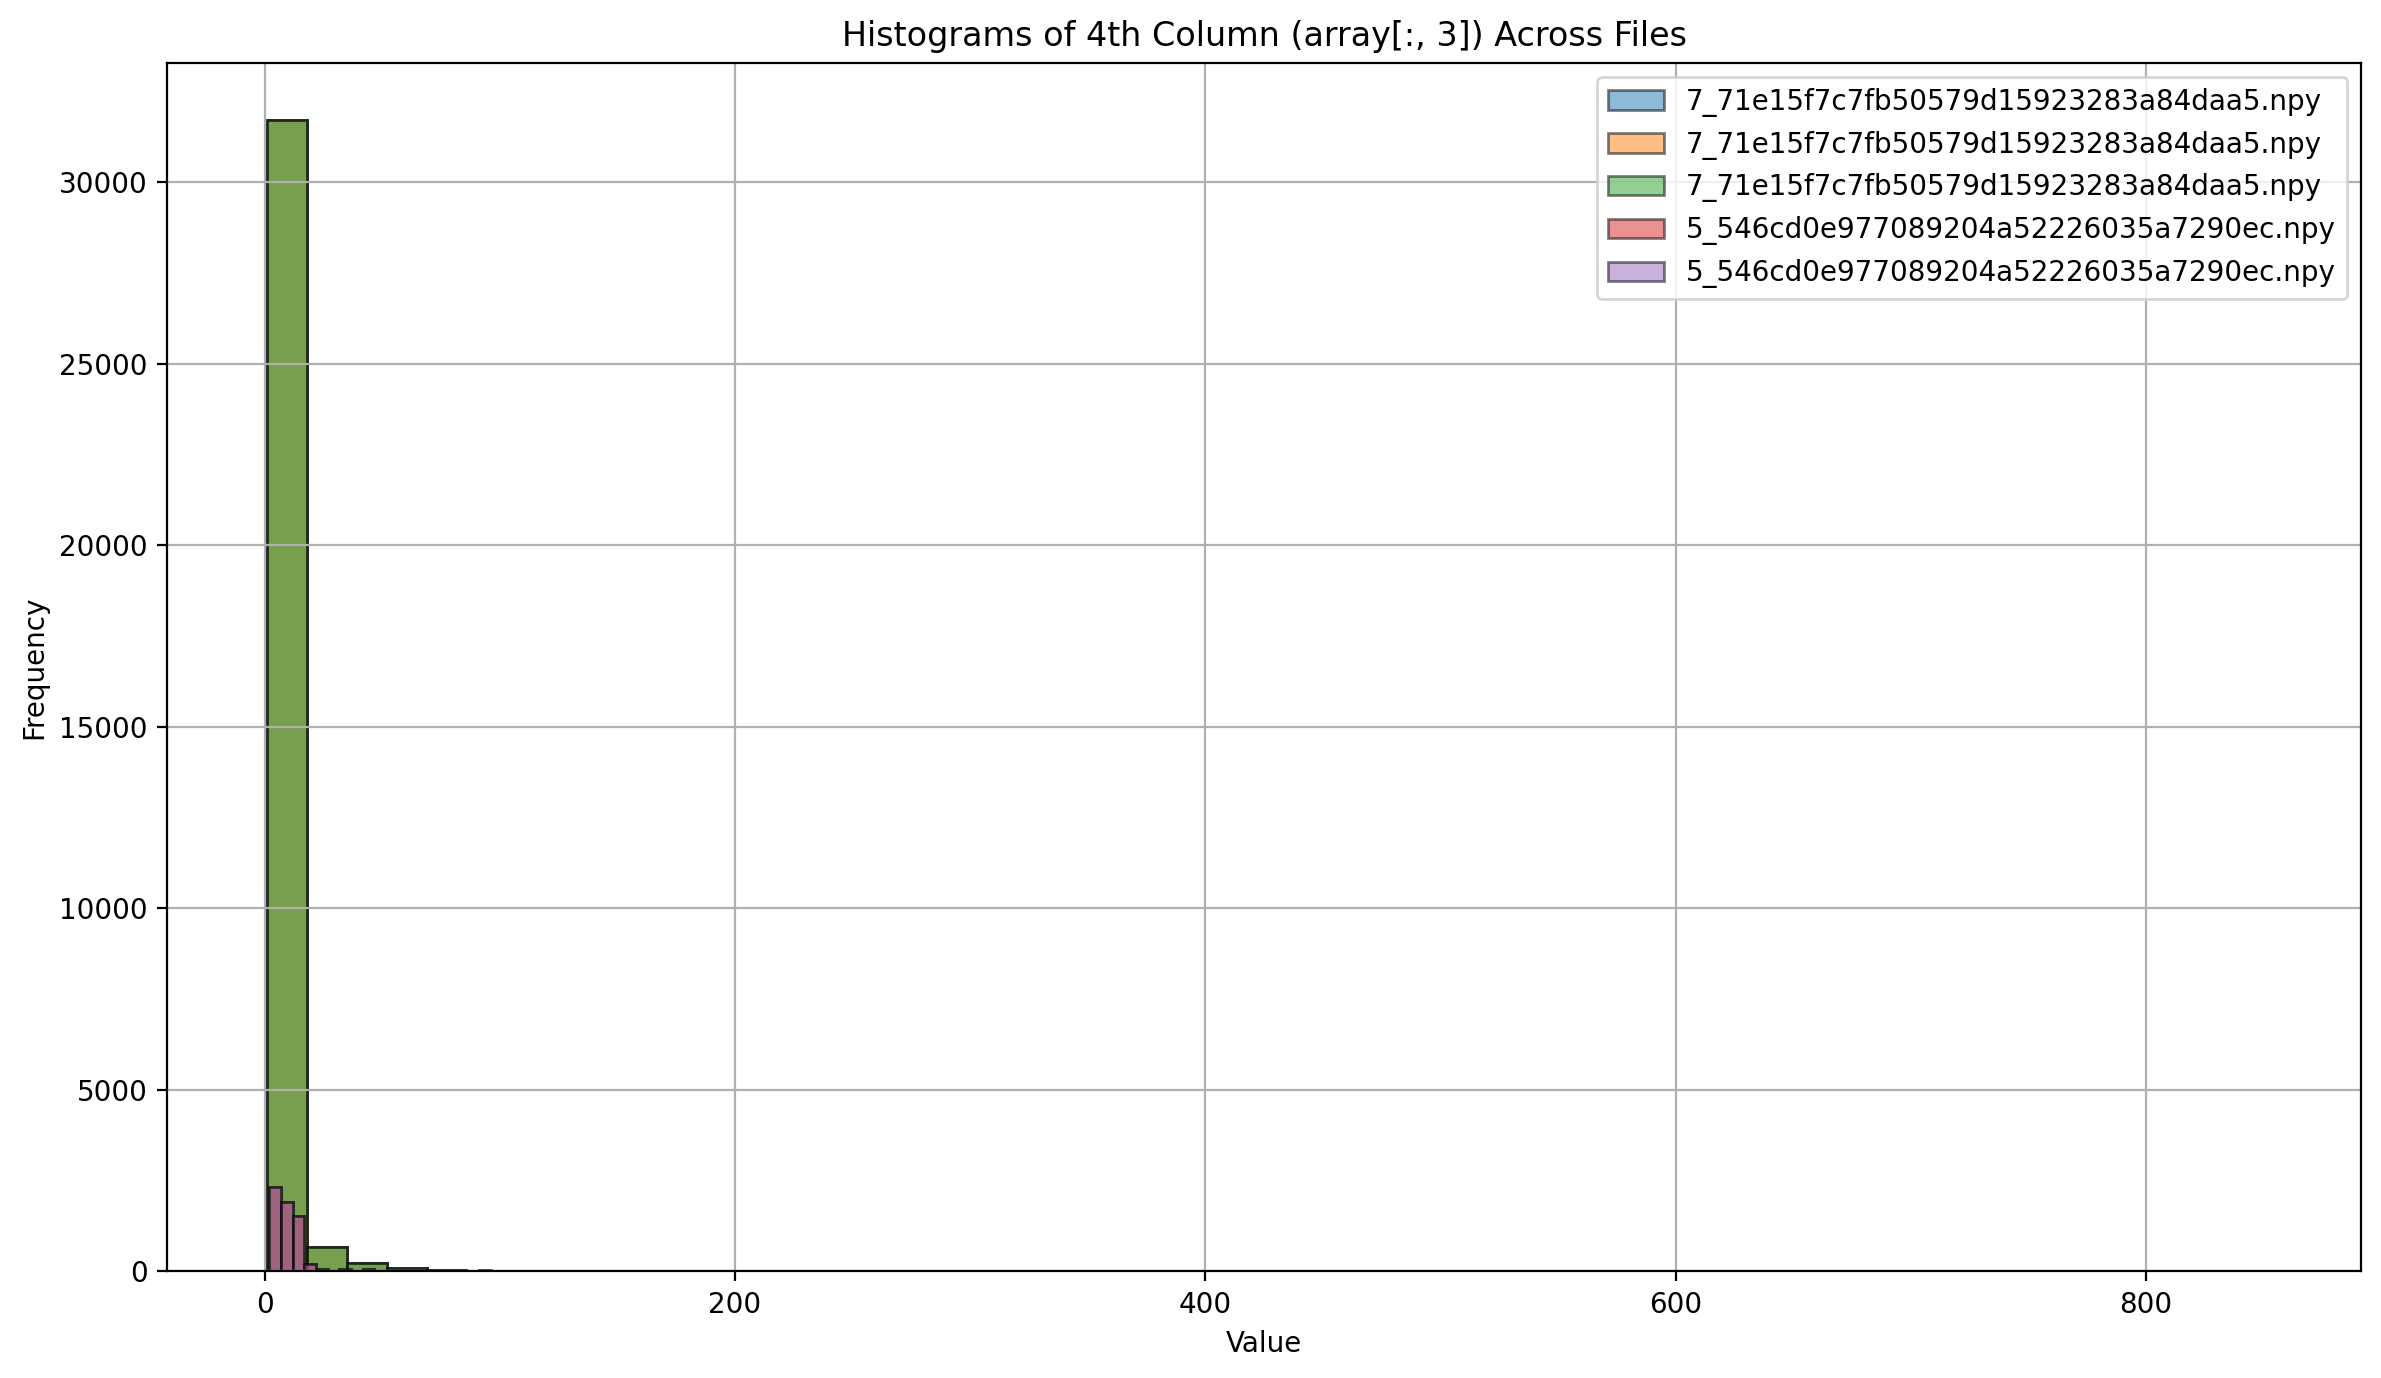

In [34]:
import os
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
import heapq

# Path to the dataset
root_dir = "/home/yihsin/dataset/midicaps-mini-parsed-mmt/train"

# Collect all .npy files recursively
npy_files = []
for dirpath, _, filenames in os.walk(root_dir):
    for file in filenames:
        if file.endswith(".npy"):
            npy_files.append(os.path.join(dirpath, file))

# Function to get top 3 values with positions and filename
def get_top_3_from_file(file_path):
    try:
        array = np.load(file_path, allow_pickle=True)
        flat = array.flatten()
        # Get indices of top 3 values
        if flat.size == 0:
            return []
        top_indices = np.argpartition(flat, -3)[-3:]
        top_values_with_info = []
        for idx in top_indices:
            val = flat[idx]
            orig_pos = np.unravel_index(idx, array.shape)
            top_values_with_info.append((val, file_path, orig_pos))
        return top_values_with_info
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return []

# Use a heap to track global top 3 values
top_k = 5
top_heap = []

# Run in parallel
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(get_top_3_from_file, path) for path in npy_files]
    for future in as_completed(futures):
        local_top = future.result()
        for item in local_top:
            if len(top_heap) < top_k:
                heapq.heappush(top_heap, item)
            else:
                heapq.heappushpop(top_heap, item)

# Sort final top 3 in descending order
top_heap.sort(reverse=True, key=lambda x: x[0])

import matplotlib.pyplot as plt
# plot historgrams
# Plot setup
plt.figure(figsize=(12, 7))

# Display results
for rank, (val, filename, position) in enumerate(top_heap, 1):
    print(f"{rank}) Value: {val}, File: {filename}, Position: {position}")
    array = np.load(filename)
    
    if array.shape[1] < 4:
        raise ValueError(f"{filename} does not have at least 4 columns.")
    
    column4 = array[:, 3]
    
    plt.hist(
        column4, 
        bins=50, 
        alpha=0.5, 
        label=filename.split('/')[-1],  # Just use filename as label
        edgecolor='black'
    )


# Final touches
plt.title('Histograms of 4th Column (array[:, 3]) Across Files')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Test REMI+ preprocessing

In [ ]:
from miditok import REMI, TokenizerConfig  # here we choose to use REMI

# Our parameters <- use default tokens & remi+ for first trial
TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": {(0, 4): 8, (4, 12): 4},
    "num_velocities": 32,
    "special_tokens": ["PAD", "BOS", "EOS", "MASK"],
    "use_chords": True,
    "use_rests": False,
    "use_tempos": True,
    "use_time_signatures": True, #remi+
    "use_programs": True,        #remi+
    "num_tempos": 32,  # number of tempo bins
    "tempo_range": (40, 250),  # (min, max)
    "one_token_stream_for_programs": True
}
config = TokenizerConfig(**TOKENIZER_PARAMS)

# Creates the tokenizer
tokenizer = REMI(config)

/home/yihsin/miniforge3/envs/mmpy11/lib/python3.11/site-packages/miditok/tokenizations/remi.py:88: UserWarning: Attribute controls are not compatible with 'config.one_token_stream_for_programs' and multi-vocabulary tokenizers. Disabling them from the config.
  super().__init__(tokenizer_config, params)


In [16]:
from pathlib import Path

# Tokenize a MIDI file
tokens = tokenizer("/home/yihsin/dataset/midicaps/lmd_full/1/157e84c82fc923cb4e0ed7ada2fb4df6.mid")  # automatically detects Score objects, paths, tokens

# Convert to MIDI and save it
generated_midi = tokenizer(tokens)  # MidiTok can handle PyTorch/Numpy/Tensorflow tensors
generated_midi.dump_midi("./decoded_midi.mid")

In [42]:
import pickle

with open("/home/yihsin/midicaps-mini-parsed/remi_plus_vocab.pkl", "wb") as f:
    pickle.dump(tokenizer.vocab, f)

In [43]:
len(tokenizer.vocab)

530

In [ ]:
# save vocab to pkl file
tokenizer.vocab

{'PAD_None': 0,
 'BOS_None': 1,
 'EOS_None': 2,
 'MASK_None': 3,
 'Bar_None': 4,
 'Pitch_21': 5,
 'Pitch_22': 6,
 'Pitch_23': 7,
 'Pitch_24': 8,
 'Pitch_25': 9,
 'Pitch_26': 10,
 'Pitch_27': 11,
 'Pitch_28': 12,
 'Pitch_29': 13,
 'Pitch_30': 14,
 'Pitch_31': 15,
 'Pitch_32': 16,
 'Pitch_33': 17,
 'Pitch_34': 18,
 'Pitch_35': 19,
 'Pitch_36': 20,
 'Pitch_37': 21,
 'Pitch_38': 22,
 'Pitch_39': 23,
 'Pitch_40': 24,
 'Pitch_41': 25,
 'Pitch_42': 26,
 'Pitch_43': 27,
 'Pitch_44': 28,
 'Pitch_45': 29,
 'Pitch_46': 30,
 'Pitch_47': 31,
 'Pitch_48': 32,
 'Pitch_49': 33,
 'Pitch_50': 34,
 'Pitch_51': 35,
 'Pitch_52': 36,
 'Pitch_53': 37,
 'Pitch_54': 38,
 'Pitch_55': 39,
 'Pitch_56': 40,
 'Pitch_57': 41,
 'Pitch_58': 42,
 'Pitch_59': 43,
 'Pitch_60': 44,
 'Pitch_61': 45,
 'Pitch_62': 46,
 'Pitch_63': 47,
 'Pitch_64': 48,
 'Pitch_65': 49,
 'Pitch_66': 50,
 'Pitch_67': 51,
 'Pitch_68': 52,
 'Pitch_69': 53,
 'Pitch_70': 54,
 'Pitch_71': 55,
 'Pitch_72': 56,
 'Pitch_73': 57,
 'Pitch_74': 58,
 'Pitc

In [ ]:
# store processed tokens to .pkl file for training
tokens.tokens

['Bar_None',
 'TimeSig_4/4',
 'Position_0',
 'Tempo_94.19',
 'Program_0',
 'Pitch_62',
 'Velocity_79',
 'Duration_2.3.8',
 'Program_0',
 'Pitch_69',
 'Velocity_95',
 'Duration_1.0.8',
 'Program_0',
 'Pitch_71',
 'Velocity_87',
 'Duration_2.3.8',
 'Program_33',
 'Pitch_43',
 'Velocity_91',
 'Duration_1.3.8',
 'Program_4',
 'Pitch_69',
 'Velocity_91',
 'Duration_2.3.8',
 'Program_4',
 'Pitch_71',
 'Velocity_83',
 'Duration_2.3.8',
 'Program_4',
 'Pitch_62',
 'Velocity_91',
 'Duration_2.3.8',
 'Program_27',
 'Pitch_71',
 'Velocity_75',
 'Duration_2.3.8',
 'Program_27',
 'Pitch_62',
 'Velocity_79',
 'Duration_2.3.8',
 'Program_27',
 'Pitch_69',
 'Velocity_87',
 'Duration_1.0.8',
 'Position_8',
 'Program_0',
 'Pitch_67',
 'Velocity_83',
 'Duration_2.3.8',
 'Program_27',
 'Pitch_67',
 'Velocity_83',
 'Duration_2.3.8',
 'Position_12',
 'Program_33',
 'Pitch_43',
 'Velocity_95',
 'Duration_0.4.8',
 'Position_16',
 'Program_33',
 'Pitch_43',
 'Velocity_87',
 'Duration_1.3.8',
 'Position_20',
 '

### Clean midicaps dataset

In [30]:
# define tokenizer
from miditok import REMI, TokenizerConfig  # here we choose to use REMI

# Our parameters <- use default tokens & remi+ for first trial
TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": {(0, 4): 8, (4, 12): 4},
    "num_velocities": 32,
    "special_tokens": ["PAD", "BOS", "EOS", "MASK"],
    "use_chords": True,
    "use_rests": False,
    "use_tempos": True,
    "use_time_signatures": True, #remi+
    "use_programs": True,        #remi+
    "num_tempos": 32,  # number of tempo bins
    "tempo_range": (40, 250),  # (min, max)
    "one_token_stream_for_programs": True
}
config = TokenizerConfig(**TOKENIZER_PARAMS)

# Creates the tokenizer
tokenizer = REMI(config)
event2idx = tokenizer.vocab

/home/yihsin/miniforge3/envs/mmpy11/lib/python3.11/site-packages/miditok/tokenizations/remi.py:88: UserWarning: Attribute controls are not compatible with 'config.one_token_stream_for_programs' and multi-vocabulary tokenizers. Disabling them from the config.
  super().__init__(tokenizer_config, params)


In [32]:
base_dir = Path("/home/yihsin/dataset/midicaps")
output_train = Path("/home/yihsin/midicaps-mini-parsed/train")
output_valid = Path("/home/yihsin/midicaps-mini-parsed/valid")
output_train.mkdir(parents=True, exist_ok=True)
output_valid.mkdir(parents=True, exist_ok=True)

In [38]:
# get 1/10 of the dataset
import random
import numpy as np
from pathlib import Path

# Base directory containing subfolders
base_dir = Path(base_dir)

# Recursively find all .mid files
all_mid_files = list(base_dir.rglob("*.mid"))
print(f"Found {len(all_mid_files)} MIDI files.")

# Randomly pick 1/10 of them
sample_size = max(1, len(all_mid_files) // 10)
sampled_files = random.sample(all_mid_files, sample_size)

# Convert to list of strings (paths)
sampled_file_paths = [str(p) for p in sampled_files]

Found 168385 MIDI files.


In [14]:
len(BEAT_CODE_MAP)

1026

In [40]:
# Find all MIDI files
all_mid_files = sampled_file_paths
print(f"Found {len(all_mid_files)} MIDI files.")

num_valid = max(1, len(all_mid_files) // 100)
valid_set = set(all_mid_files[:num_valid])

for i, mid_path in enumerate(all_mid_files):
    # Derive unique name: <subfolder>_<id>.npy
    pth_obj = Path(mid_path)
    relative = pth_obj.relative_to(base_dir)
    subfolder = relative.parts[-2]
    stem = pth_obj.stem  # filename without .mid
    filename = f"{subfolder}_{stem}.npy"

    try:
        tokens = tokenizer(mid_path).tokens
        arr = np.array([event2idx[e] for e in tokens])
    except Exception as e:
        print(f"[!] Failed to process {mid_path}: {e}")
        continue

    # Choose folder
    if mid_path in valid_set:
        out_path = output_valid / filename
    else:
        out_path = output_train / filename

    np.save(out_path, arr)

    if i % 100 == 0:
        print(f"Processed {i}/{len(all_mid_files)}")

print("✅ Done.")

Found 16838 MIDI files.
Processed 0/16838
Processed 100/16838
Processed 200/16838
Processed 300/16838
Processed 400/16838
Processed 500/16838
Processed 600/16838
Processed 700/16838
Processed 800/16838
Processed 900/16838
Processed 1000/16838
Processed 1100/16838
Processed 1200/16838
Processed 1300/16838
Processed 1400/16838
Processed 1500/16838
Processed 1600/16838
Processed 1700/16838
Processed 1800/16838
Processed 1900/16838
Processed 2000/16838
Processed 2100/16838
Processed 2200/16838
Processed 2300/16838
Processed 2400/16838
Processed 2500/16838
Processed 2600/16838
Processed 2700/16838
Processed 2800/16838
Processed 2900/16838
Processed 3000/16838
Processed 3100/16838
Processed 3200/16838
Processed 3300/16838
Processed 3400/16838
Processed 3500/16838
Processed 3600/16838
Processed 3700/16838
Processed 3800/16838
Processed 3900/16838
Processed 4000/16838
Processed 4100/16838
Processed 4200/16838
Processed 4300/16838
Processed 4400/16838
Processed 4500/16838
Processed 4600/16838
P

In [41]:
np.load("/home/yihsin/midicaps-mini-parsed/train/f_fd7b815a42b30bb3fd3f64230698e7a6.npy")

array([  4, 529, 189, ...,  59, 114, 172], shape=(14635,))